In [1]:
import sys
sys.path.append('/Users/bilgecagaydogdu/Desktop/mobile_phone_indicators/')

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plts
from shapely.geometry import Point
import pandas as pd
import warnings
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta
from helper_functions.finegrained_helper import read_fine_grained,customer_signals_analysis,calculate_date_values,filter_customers
from helper_functions.antenna_helper import read_antenna_data,dataframe_length_calculator,antenna_variable_histogram,antenna_aggregate_calls
from helper_functions.tower_helper import read_tower_data,find_sites_in_buffer,plot_sites,create_point_buffer
from segregation_indicators.social_indicators import social_connectedness_antenna
from mobility_indicators.simple_migration_flow_indicators import frequency_based_aggregation
from mobility_indicators.mobility_indicators import o_d_matrix
from helper_functions.map_helper import read_map_district
from helper_functions.utilities import get_location_level
from segregation_indicators.social_indicators import social_connectedness_antenna
import scipy
from mobility_indicators.simple_migration_flow_indicators import daily_home_location_series
target_crs = "EPSG:32635"  # Change as per your requirement
district_maps = "/Users/bilgecagaydogdu/Desktop/Geodirectory/turkey_administrativelevels0_1_2/tur_polbnda_adm2.shp"
tower_location="/Volumes/Extreme Pro/Cell_Tower_Locations/cell_city_district.txt"
voronoi="/Volumes/Extreme Pro/Cell_Tower_Locations/turkcell_voronoi/voronoi.shp"


<h1> OD flows

In [2]:
df=pd.read_csv('/Volumes/Extreme Pro/calculated_indicators/dailyhomelocationsscikit_earthquake.csv', index_col=0).rename(columns={'user_id':'customer_id','date':'time','location':'site_id','segment_caller':'segment'})
df["time"]=pd.to_datetime(df['time'], format='%Y%m%d') 
tower_location="/Volumes/Extreme Pro/Cell_Tower_Locations/cell_city_district.txt"
df_tower=read_tower_data(tower_location)
gdf_districts = read_map_district(district_maps)
gdf_districts=df_tower.drop_duplicates(subset=["city_district_id"]).drop(columns=['site_id','city','district']).merge(gdf_districts, on=['city_district'],how='left')
df=df.merge(df_tower[['city_id','city_district_id','site_id']],on='site_id',how='left')

In [3]:
df_od=o_d_matrix(df, 'city', 'week','city','day',time_format='%Y%m%d')
weekly_od_matrix=df_od.merge(gdf_districts.drop_duplicates(subset='city').reset_index()[['city_id','city']],right_on='city_id',left_on='destination_loc',how='left')\
    .rename(columns={'city':'destination_city'}).drop(columns=['city_id']).merge(gdf_districts.drop_duplicates(subset='city').reset_index()[['city_id','city']]\
                                                                                  ,right_on='city_id',left_on='origin_loc',how='left').rename(columns={'city':'origin_city'})



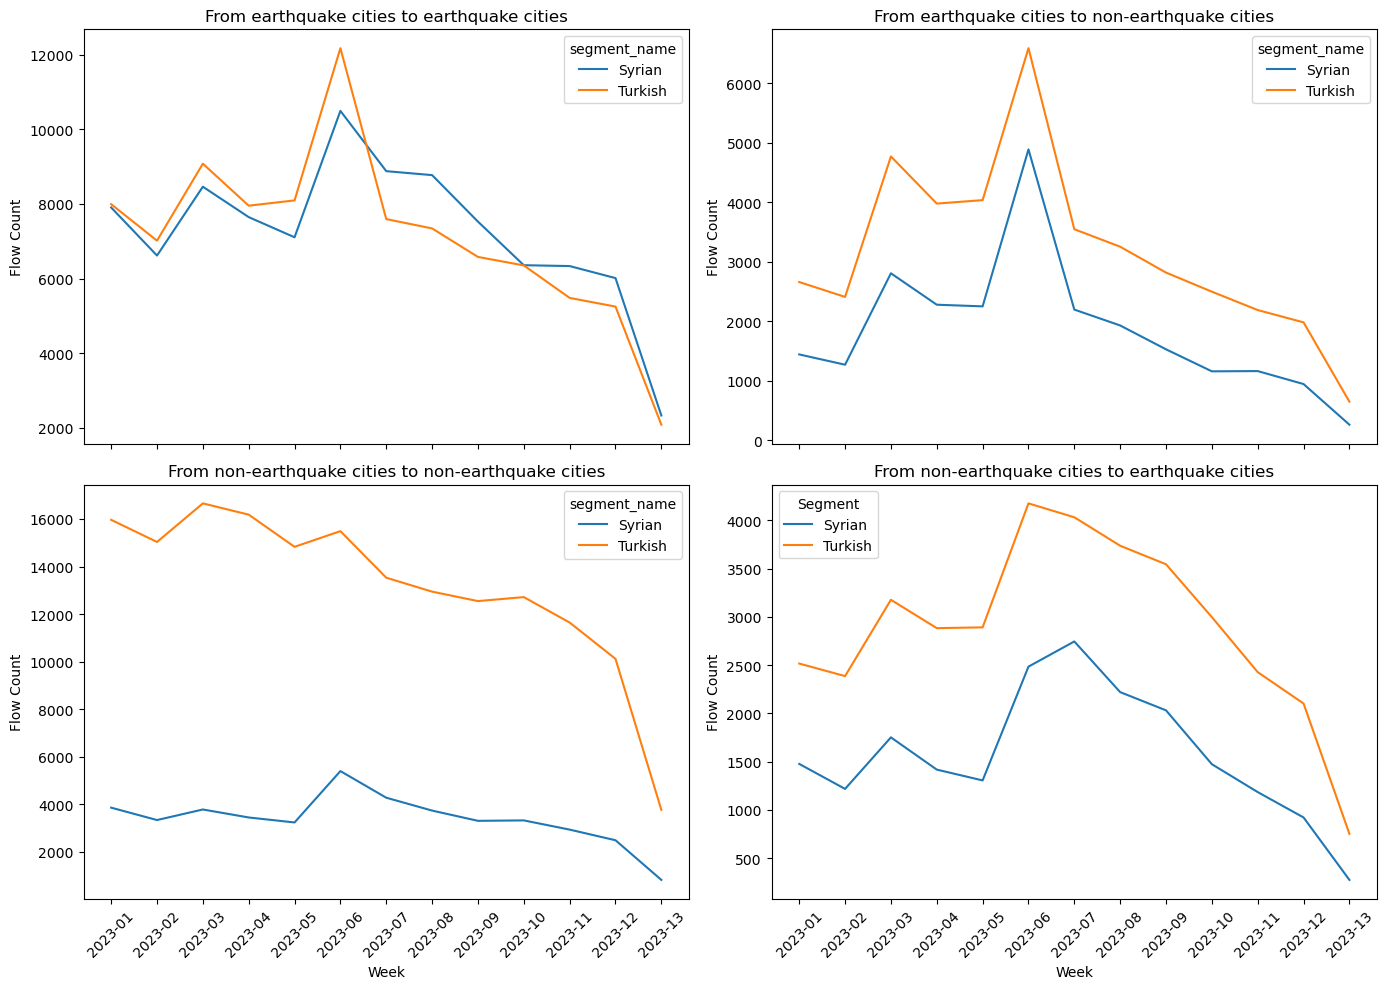

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your DataFrame
# weekly_od_matrix = ...

# Assuming 'weekly_od_matrix' is already loaded and includes the necessary columns
# Map segments to names
weekly_od_matrix['segment_name'] = weekly_od_matrix['segment'].map({1: 'Turkish', 2: 'Syrian'})

# Create the new columns based on earthquake_cities
earthquake_cities = [42, 33, 37, 65, 2, 69, 26, 56, 48, 1]
weekly_od_matrix['origin_earthquake'] = weekly_od_matrix['origin_loc'].apply(lambda x: 1 if x in earthquake_cities else 2)
weekly_od_matrix['destination_earthquake'] = weekly_od_matrix['destination_loc'].apply(lambda x: 1 if x in earthquake_cities else 2)

# Aggregate data
aggregated_df = weekly_od_matrix.groupby(['week', 'segment_name', 'origin_earthquake', 'destination_earthquake'])['flow_count'].sum().reset_index()

# Exclude week "2022-52"
filtered_df = aggregated_df[aggregated_df['week'] != '2022-52']

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
combinations = [(1, 1), (1, 2), (2, 2), (2, 1)]
titles = [
    "From earthquake cities to earthquake cities",
    "From earthquake cities to non-earthquake cities",
    "From non-earthquake cities to non-earthquake cities",
    "From non-earthquake cities to earthquake cities"
]

for ax, (origin_eq, dest_eq) in zip(axs.flat, combinations):
    sns.lineplot(data=filtered_df[(filtered_df['origin_earthquake'] == origin_eq) & (filtered_df['destination_earthquake'] == dest_eq)], 
                 x='week', y='flow_count', hue='segment_name', ax=ax)
    ax.set_title(titles[combinations.index((origin_eq, dest_eq))])
    ax.set_ylabel('Flow Count')
    ax.set_xlabel('Week')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()

# Ensure the legend is visible
plt.legend(title='Segment', loc='upper left')

plt.show()


<h1> Social indicators

In [3]:
ei=pd.read_csv("/Volumes/Extreme Pro/calculated_indicators/ei_city.csv", index_col=0)
ei=ei.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_caller',how='left')
antenna_social=pd.read_csv("/Volumes/Extreme Pro/calculated_indicators/sci_city.csv", index_col=0)
antenna_social=antenna_social.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_caller',how='left').rename(columns={'city':'city_caller'}).drop(columns=['city_id'])
antenna_social=antenna_social.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_callee',how='left').rename(columns={'city':'city_callee'}).drop(columns=['city_id'])

In [40]:
antenna_social2=antenna_social[['city_id_caller','city_id_callee','week','call_duration','total_call_count_callee','total_call_duration_callee','total_call_count_caller','total_call_duration_caller']].groupby(["city_id_callee","city_id_caller","week"]).sum().reset_index()
#antenna_social2['sci']=antenna_social2['call_duration']/(antenna_social2['total_call_duration_callee']*antenna_social2['total_call_duration_caller'])

In [41]:
def normalize_city_pairs(row):
    """Normalize city_id pairs to ensure uniqueness."""
    sorted_cities = sorted([row['city_id_callee'], row['city_id_caller']])
    return pd.Series(sorted_cities, index=['norm_city_id_callee', 'norm_city_id_caller'])

# Normalize city pairs
antenna_social2[['norm_city_id_caller', 'norm_city_id_callee']] = antenna_social2.apply(normalize_city_pairs, axis=1)

# Aggregate data
aggregated_data = antenna_social2.groupby(['norm_city_id_callee', 'norm_city_id_caller', 'week']).agg({
    'call_duration': 'sum',
    'total_call_count_callee': 'sum',
    'total_call_duration_callee': 'sum',
    'total_call_count_caller': 'sum',
    'total_call_duration_caller': 'sum'
}).reset_index()

# Calculate SCI
aggregated_data['sci'] = aggregated_data['call_duration'] / (aggregated_data['total_call_duration_callee'] * aggregated_data['total_call_duration_caller'])
sci=aggregated_data[aggregated_data['week'].isin([1,2,3,4])].reset_index(drop=True).groupby(['norm_city_id_caller','norm_city_id_callee'])['sci'].mean().reset_index()
# Drop the normalization columns if no longer needed
#aggregated_data.drop(['norm_city_id_callee', 'norm_city_id_caller'], axis=1, inplace=True)



In [26]:
od_of_interest=weekly_od_matrix[(weekly_od_matrix['week']=='2023-06')|(weekly_od_matrix['week']=='2023-07')].groupby(['origin_loc','destination_loc'])['flow_count'].sum().reset_index()

In [79]:
weekly_od_matrix['week'] = weekly_od_matrix['week'].str.split('-').str[1].astype(int)


In [80]:
antenna_social2['week']=antenna_social2['week'].astype(int)
antenna_social2['city_id_caller']=antenna_social2['city_id_caller'].astype(int)
antenna_social2['city_id_callee']=antenna_social2['city_id_callee'].astype(int)
weekly_od_matrix['week']=weekly_od_matrix['week'].astype(int)
weekly_od_matrix['origin_loc']=weekly_od_matrix['origin_loc'].astype(int)
weekly_od_matrix['destination_loc']=weekly_od_matrix['destination_loc'].astype(int)

In [87]:
merged=weekly_od_matrix.merge(antenna_social2[['week','city_id_caller','city_id_callee','call_duration','total_call_duration_caller','total_call_duration_callee'\
                                            ]],right_on=['week','city_id_caller','city_id_callee'],left_on=['week','destination_loc','origin_loc'],how='left')\
.rename(columns={"call_duration":"call_duration_destination_caller",\
                "total_call_duration_caller":"total_call_duration_destination_caller",\
                "total_call_duration_callee":"total_call_duration_origin_callee"})


In [89]:
merged

,week,segment,origin_loc,destination_loc,flow_count,destination_city,city_id,origin_city,city_id_caller,city_id_callee,call_duration_destination_caller,total_call_duration_destination_caller,total_call_duration_origin_callee
0,52,1,1,5,1,AKSARAY,1,ADANA,NaN,NaN,NaN,NaN,NaN
1,52,1,1,7,6,ANKARA,1,ADANA,NaN,NaN,NaN,NaN,NaN
2,52,1,1,8,2,ANTALYA,1,ADANA,NaN,NaN,NaN,NaN,NaN
3,52,1,1,14,2,BATMAN,1,ADANA,NaN,NaN,NaN,NaN,NaN
4,52,1,1,17,1,BINGOL,1,ADANA,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52924,13,5,74,40,3,ISTANBUL,74,TEKIRDAG,NaN,NaN,NaN,NaN,NaN
52925,13,5,74,50,3,KIRKLARELI,74,TEKIRDAG,NaN,NaN,NaN,NaN,NaN
52926,13,5,76,66,2,RIZE,76,TRABZON,NaN,NaN,NaN,NaN,NaN
52927,13,5,77,29,1,ELAZIG,77,TUNCELI,NaN,NaN,NaN,NaN,NaN


In [86]:
merged=merged.merge(antenna_social2[['week','city_id_caller','city_id_callee','call_duration','total_call_duration_caller','total_call_duration_callee'\
                                            ]],right_on=['week','city_id_caller','city_id_callee'],left_on=['week','origin_loc','destination_loc'],how='left')\
.rename(columns={"call_duration":"call_duration_origin_caller",
                "total_call_duration_caller":"total_call_duration_origin_caller",
                "total_call_duration_callee":"total_call_duration_destination_callee",})



,city_id_callee,city_id_caller,week,call_duration,total_call_count_callee,total_call_duration_callee,total_call_count_caller,total_call_duration_caller,norm_city_id_caller,norm_city_id_callee
0,1,2,1,65862,212416.0,26744712.0,18022,2364808,1.0,2.0
1,1,2,2,63642,194192.0,25325674.0,15711,2079264,1.0,2.0
2,1,2,3,73432,214409.0,27480324.0,17048,2229051,1.0,2.0
3,1,2,4,67855,213583.0,27764514.0,17120,2344542,1.0,2.0
4,1,2,5,143064,372882.0,48847511.0,29359,4038910,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
73669,82,81,8,3160,1384.0,286998.0,15085,1898937,81.0,82.0
73670,82,81,9,1264,1412.0,273076.0,15968,2040098,81.0,82.0
73671,82,81,10,4219,1425.0,268356.0,14967,2093245,81.0,82.0
73672,82,81,11,2443,1161.0,197205.0,13160,1831089,81.0,82.0


In [ ]:
merged=od_of_interest.merge(antenna_social2,right_on=['norm_city_id_caller'],left_on=['destination_loc'],how='left').rename(columns={"sci":"sci_origin"})

merged=merged[merged['sci_origin'].isnull()==False].reset_index(drop=True)
scipy.stats.pearsonr(merged['sci_origin'], merged['flow_count'])


In [75]:
antenna_social2

,city_id_callee,city_id_caller,week,call_duration,total_call_count_callee,total_call_duration_callee,total_call_count_caller,total_call_duration_caller,norm_city_id_caller,norm_city_id_callee
0,1.0,2.0,1,65862,212416.0,26744712.0,18022,2364808,1.0,2.0
1,1.0,2.0,2,63642,194192.0,25325674.0,15711,2079264,1.0,2.0
2,1.0,2.0,3,73432,214409.0,27480324.0,17048,2229051,1.0,2.0
3,1.0,2.0,4,67855,213583.0,27764514.0,17120,2344542,1.0,2.0
4,1.0,2.0,5,143064,372882.0,48847511.0,29359,4038910,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
73669,82.0,81.0,8,3160,1384.0,286998.0,15085,1898937,81.0,82.0
73670,82.0,81.0,9,1264,1412.0,273076.0,15968,2040098,81.0,82.0
73671,82.0,81.0,10,4219,1425.0,268356.0,14967,2093245,81.0,82.0
73672,82.0,81.0,11,2443,1161.0,197205.0,13160,1831089,81.0,82.0


In [73]:
weekly_od_matrix[weekly_od_matrix['origin_loc']==33]

,week,segment,origin_loc,destination_loc,flow_count,destination_city,city_id,origin_city
360,2022-52,1,33,1,16,ADANA,33,GAZIANTEP
361,2022-52,1,33,2,26,ADIYAMAN,33,GAZIANTEP
362,2022-52,1,33,5,1,AKSARAY,33,GAZIANTEP
363,2022-52,1,33,7,2,ANKARA,33,GAZIANTEP
364,2022-52,1,33,8,4,ANTALYA,33,GAZIANTEP
...,...,...,...,...,...,...,...,...
52418,2023-13,2,33,69,346,SANLIURFA,33,GAZIANTEP
52419,2023-13,2,33,79,1,VAN,33,GAZIANTEP
52721,2023-13,3,33,7,1,ANKARA,33,GAZIANTEP
52722,2023-13,3,33,36,2,HAKKARI,33,GAZIANTEP


In [74]:
antenna_social2

,city_id_callee,city_id_caller,week,call_duration,total_call_count_callee,total_call_duration_callee,total_call_count_caller,total_call_duration_caller,norm_city_id_caller,norm_city_id_callee
0,1.0,2.0,1,65862,212416.0,26744712.0,18022,2364808,1.0,2.0
1,1.0,2.0,2,63642,194192.0,25325674.0,15711,2079264,1.0,2.0
2,1.0,2.0,3,73432,214409.0,27480324.0,17048,2229051,1.0,2.0
3,1.0,2.0,4,67855,213583.0,27764514.0,17120,2344542,1.0,2.0
4,1.0,2.0,5,143064,372882.0,48847511.0,29359,4038910,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
73669,82.0,81.0,8,3160,1384.0,286998.0,15085,1898937,81.0,82.0
73670,82.0,81.0,9,1264,1412.0,273076.0,15968,2040098,81.0,82.0
73671,82.0,81.0,10,4219,1425.0,268356.0,14967,2093245,81.0,82.0
73672,82.0,81.0,11,2443,1161.0,197205.0,13160,1831089,81.0,82.0
